In [28]:
import torch
from torch import nn


In [29]:
def corr2d(X,K):
  """计算二维互相关运算"""
  h,w = K.shape
  Y =  torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i,j] = (X[i:i+h,j:j+w] * K).sum()
  return Y
  

In [30]:
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

# 卷积层定义
高度和宽度为(h,w)的卷积核被称为h x w的卷积核，将带有hxw的卷积核的卷积层称为h x w卷积层

In [31]:
class Conv2d(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros)
    
  def forward(self, x):
    return corr2d(x,self.weight) + self.bias

## 应用：边缘检测

In [32]:
# 构造6x8的黑白图像，中间为黑，两边为白
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [33]:
# 构造1x2的卷积核
K = torch.tensor([[1.0,-1.0]])


In [34]:
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [35]:
# 如果将输入的二维图像转置，就检测不到边缘了，因为这个卷积核只能检测垂直边缘
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核
能不能通过"输入-输出"对来学习由X生成Y的卷积核？
这里比较Y与卷积层输出的平方误差，然后计算梯度来更新卷积核，我们使用内置二维卷积层以及忽略偏置

In [36]:
# 二维卷积层，1批量大小，1通道，形状(1,2)
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小，通道， 高度， 宽度）
# 其中批量大小和通道数都为1
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(12):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # 迭代卷积核
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i+1) % 2 == 0:
    print(f'epoch {i+1} , loss {l.sum():.3f}')

epoch 2 , loss 8.879
epoch 4 , loss 2.708
epoch 6 , loss 0.953
epoch 8 , loss 0.364
epoch 10 , loss 0.145
epoch 12 , loss 0.059


In [37]:
conv2d.weight.data.reshape((1,2))

tensor([[ 1.0207, -0.9709]])

## 填充

In [38]:
import torch
from torch import nn

def comp_conv2d(conv2d, X):
  """初始化卷积层权重，并对input和output提高和缩减相对应的维数"""
  # 这里的(1,1)表示批量大小和通道数
  X = X.reshape((1,1)+X.shape)
  Y = conv2d(X)
  # 省略批量大小和通道
  return Y.reshape(Y.shape[2:])

# 每边都填充1列或1行，一共扩充2行2列
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [39]:
# 卷积核高度和宽度不变，填充不同的高度和宽度，使得输出和输入具有相同的高度和宽度
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

## 步幅

In [40]:
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [41]:
# 改变水平步幅和垂直步幅
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([3, 2])

## 多输入通道
卷积核的通道数一定要和输入数据的通道数相同，对每个通道执行卷积然后相加

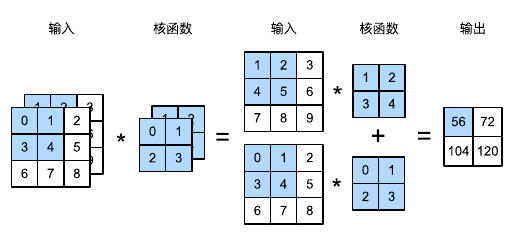

In [42]:
import torch
def corr2d_multi_in(X,K):
  # 先遍历X和K的第0个维度，再把他们加在一起
  return sum(corr2d(x,k) for x,k in zip(X,K))


In [43]:
X = torch.tensor([[[0,1,2],[3,4,5],[6,7,8]],
                  [[1,2,3],[4,5,6],[7,8,9]]])
K = torch.tensor([[[0,1],[2,3]],[[1,2],[3,4]]])
corr2d_multi_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道
每个通道都来c个卷积核，那么就有c个输出通道

In [44]:
def corr2d_multi_in_out(X,K):
  # 迭代"K"的第0个维度，每次都对输入X执行卷积
  return torch.stack([corr2d_multi_in(X,k) for k in K],0)
# 将核张量K与K+1和K+2连接起来
K = torch.stack((K,K+1,K+2),0)
K.shape

torch.Size([3, 2, 2, 2])

In [45]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# 1X1卷积层

In [46]:
def corr2d_multi_in_out_1x1(X,K):
  c_i,h,w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i,h*w))
  K = K.reshape((c_o,c_i))
  # 全连接层的矩阵乘法
  Y = torch.matmul(K,X)
  return Y.reshape((c_o,h,w))

In [47]:
X = torch.normal(0,1,(3,3,3))
K = torch.normal(0,1,(2,3,1,1))

In [48]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X,K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6